### Introduction <br/>

This notebook example will walk you through the major steps the <a href="https://exoctk.stsci.edu/contam_visibility">Contamination Overlap tool</a> takes to predict which nearby sources will contaminate your target and where. The notebook pulls from our fieldSim.py module, which generates a simulated science image at every Aperture Position Angle (APA) of the selected instrument. For each major step, a matplotlib image will be generated as a visual aid. You are not required to modify anything outside of the `INPUT PARAMTERS` cells, designated accordingly.<br/>

The `INPUT PARAMETERS` cells are pre-filled with an example, but you may modify them with parameters for your specific observations, if it helps to conceptualize the code.  <br/>

The final product of this notebook is a simulated science image at the given APA. This is essentially the science image used to calculate the contamination levels at every APA of the instrument. <br/> 

The mini tool `contamVerify` has been built as a companion to the Contamination Overlap tool, and runs through all of the major steps demonstrated in this notebook to generate a PDF file of science images for a list of APAs you feed it. In the last cell we show you how you can use this tool for verification purposes either in this Jupyter notebook or in a terminal.

In [5]:
import glob
import os
import pysiaf

import astropy.coordinates as crd
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astroquery.irsa import Irsa
from matplotlib import cm
from scipy.io import readsav
from astropy.io import fits
from exoctk.utils import get_env_variables
from exoctk.contam_visibility.miniTools import traceLength, plotTemps

%matplotlib inline

### Step 1: Query the surrounding region of your target <br/>

The first parameters being fed to the tool are the target's sky coordinates (RA, DEC) and the JWST instrument being used for observation. Once that is provided, the software will begin by querying all the point-sources within a 2.5 arcminute radius of the target. The catalog currently used for this query is 2MASS's IRSA point-source catalog. One of the future improvements of the Contamination Overlap tool will include querying for extended sources, as they may also be potential contaminants.<br/>

When querying is complete, the (RA, DEC) coordinates of each neighbor source is collected and stored in a dictionary for later calculations. <br/>

The first output will show an example of a query result for the RA, DEC inputs at V3PA = 0. This is the similar to the field of view you would see in APT's Aladin. 

In [6]:
############################################## INPUT PARAMETERS ##################################################
RA, DEC = '19:50:50.2400', '+48:04:51.00' # HAT P 11
INSTRUMENT = 'NIRCam F444W' # Make sure to put in the specific filter if using NIRCam (i.e. `NIRCam F444W` or `NIRCam F322W2`)
APA = 0 # Aperture Position Angle in degrees. This is the angle we plot on the website.
##################################################################################################################

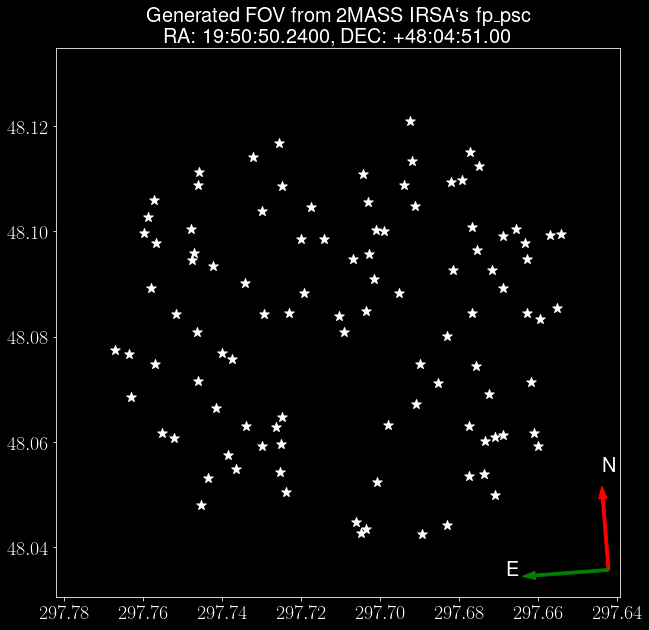

In [11]:
# Converting to degrees 
targetcrd = crd.SkyCoord(ra=RA, dec=DEC, unit=(u.hourangle, u.deg))
targetRA = targetcrd.ra.value
targetDEC = targetcrd.dec.value

# Querying for neighbors with 2MASS IRSA's fp_psc (point-source catalog)
info = Irsa.query_region(targetcrd, catalog='fp_psc', spatial='Cone', radius=2.5*u.arcmin)

# Coordinates of all stars in FOV, including target
allRA = info['ra'].data.data
allDEC = info['dec'].data.data

# Initiating a dictionary to hold all relevant star information 
stars = {}
stars['RA'], stars['DEC'] = allRA, allDEC

# Plotting
plt.figure(figsize=(10.1,10.1))
plt.scatter(stars['RA'], stars['DEC'], marker='*', color='white', s=100, edgecolor='white')

# Plot styling 
plt.style.use('dark_background')
plt.gca().invert_xaxis() # re-orient to have East going left
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Generated FOV from 2MASS IRSA`s fp\_psc'+'\n'+'RA: {}, DEC: {}'.format(RA, DEC), fontsize=20)

ax = plt.gca()
plt.arrow(x=0.98, y=0.05, dx=-0.01, dy=0.13, color='red', width=0.005, transform=ax.transAxes)
plt.text(x=0.97, y=0.23, s='N', fontsize=20, transform=ax.transAxes)
plt.arrow(x=0.98, y=0.05, dx=-0.13, dy=-0.01, color='green', width=0.005, transform=ax.transAxes)
plt.text(x=0.8, y=0.04, s='E', fontsize=20, transform=ax.transAxes)

plt.show()

### Step 2: Assign the target an index <br/>

The target's information will need to be indexed several times throughout the pipeline, so we find the index by calculating the relative distance between the target and every source from the query. Of course the target will have a distance of 0 away from itself, and the index of that element is what we will call the `targetIndex` for the rest of the pipeline. <br/>

The following output is the same FOV from above but with the target circled in red.

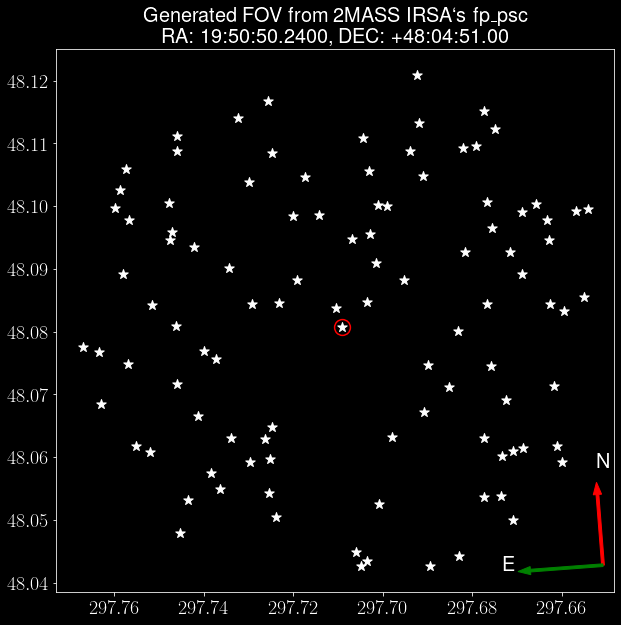

In [8]:
sindRA = (targetRA-stars['RA'])*np.cos(targetDEC)
cosdRA = targetDEC-stars['DEC']
distance = np.sqrt(sindRA**2 + cosdRA**2)
targetIndex = np.argmin(distance)

# Plotting
plt.figure(figsize=(10,10))
plt.scatter(stars['RA'][targetIndex], stars['DEC'][targetIndex], s=250, lw=1.5, facecolor='k', edgecolor='red')
plt.scatter(stars['RA'], stars['DEC'], marker='*', color='white', s=100, edgecolor='white')

# Plot styling 
plt.style.use('dark_background')
plt.gca().invert_xaxis() # re-orient to have East going left
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Generated FOV from 2MASS IRSA`s fp\_psc'+'\n'+'RA: {}, DEC: {}'.format(RA, DEC), fontsize=20)

ax = plt.gca()
plt.arrow(x=0.98, y=0.05, dx=-0.01, dy=0.13, color='red', width=0.005, transform=ax.transAxes)
plt.text(x=0.97, y=0.23, s='N', fontsize=20, transform=ax.transAxes)
plt.arrow(x=0.98, y=0.05, dx=-0.13, dy=-0.01, color='green', width=0.005, transform=ax.transAxes)
plt.text(x=0.8, y=0.04, s='E', fontsize=20, transform=ax.transAxes)

plt.show()

Our tool also allows for the option to add a missing companion that is not already in the 2MASS IRSA point-source catalog. When you're on the website, this companion will be factored into the final result when added into the following field: 

<br/>
<img src='figures/binCompsField.png' width=1500>
<br/>

Consider using that field if you are using your own target in the notebook and there is a companion missing in the output FOV above. Fill out the ``INPUT PARAMETERS`` section in the cell below with a comma-separated list of the following:  <br/>

* #### RA (string - HH:MM:SS)
* #### DEC (string - DD:MM:SS)
* #### J magnitude (float or integer)
* #### H magnitude (float or integer)
* #### K magnitude (float or integer) <br/>


The cell below will be pre-filled with an example for HAT-P 11.

In [9]:
EXOCTK_DATA = os.environ.get('EXOCTK_DATA')
TRACES_PATH = os.path.join(EXOCTK_DATA,  'exoctk_contam', 'traces')
   
# Restoring model parameters
modelParam = readsav(os.path.join(TRACES_PATH, 'NIRISS', 'modelsInfo.sav'),
                     verbose=False)
models = modelParam['models']
modelPadX = modelParam['modelpadx']
modelPadY = modelParam['modelpady']
dimXmod = modelParam['dimxmod']
dimYmod = modelParam['dimymod']
jhMod = modelParam['jhmod']
hkMod = modelParam['hkmod']
teffMod = modelParam['teffmod']

# JHK bands of all stars in FOV, including target
Jmag = info['j_m'].data.data
Hmag = info['h_m'].data.data
Kmag = info['k_m'].data.data

In [10]:
############################################## INPUT PARAMETERS ##################################################
#         [RA (arcsec), DEC (arcsec), 2MASS J (mag), 2MASS H (mag), 2MASS K (mag)]
#binComp = ['19:50:53.56', '+48:05:0.43', 16.159, 15.700, 15.191] 
binComp = [297.723183, +48.084534, 16.159, 15.700, 15.191] 
##################################################################################################################
deg2rad = np.pi/180

if binComp != []:
    bb = binComp[0]/3600/np.cos(allDEC[targetIndex]*deg2rad)
    allRA = np.append(allRA, (allRA[targetIndex] + bb))
    allDEC = np.append(allDEC, (allDEC[targetIndex] + binComp[1]/3600))
    Jmag = np.append(Jmag, binComp[2])
    Hmag = np.append(Kmag, binComp[3])
    Kmag = np.append(Kmag, binComp[4])
    J_Hobs = Jmag-Hmag
    H_Kobs = Hmag-Kmag

### Step 3: Calculate stellar temperatures <br/>

Now we have a catalog of stars at our disposal. The target and its neighbors will be assigned a pre-generated trace corresponding to effective temperature T. As such, we need to know the temperature of each star to assign it the right spectral trace. The following cell shows how the Contamination Overlap tool calculates these temperatures, and the next output will plot the sources from our FOV, with a color pallette scaled according to effective temperature.  

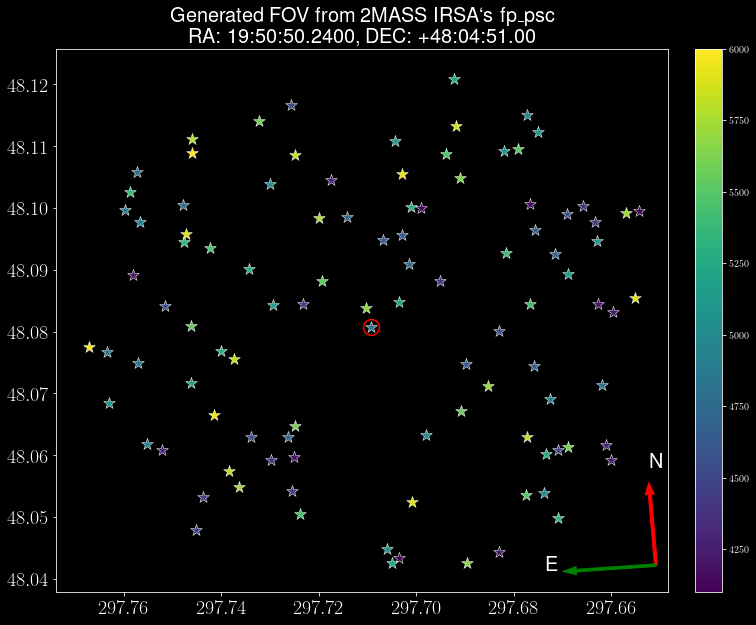

In [13]:
# J-H band, H-K band. This will be used to derive the stellar Temps later
J_Hobs = Jmag-Hmag
H_Kobs = Hmag-Kmag

# Number of stars
nStars = stars['RA'].size
    
# Find/assign Teff of each star
starsT = np.empty(nStars)
for j in range(nStars):
    color_separation = (J_Hobs[j]-jhMod)**2+(H_Kobs[j]-hkMod)**2
    min_separation_ind = np.argmin(color_separation)
    starsT[j] = teffMod[min_separation_ind]

# Record keeping
stars['Temp'] = starsT

# Plotting
plt.figure(figsize=(12,10))
plt.scatter(targetRA, targetDEC, s=250, lw=1.5, facecolor='k', edgecolor='red')
plotTemps(stars['Temp'], allRA, allDEC)
    
# Plot styling
plt.gca().invert_xaxis() # re-orient to have East going left
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Generated FOV from 2MASS IRSA`s fp\_psc'+'\n'+'RA: {}, DEC: {}'.format(RA, DEC), fontsize=20)

ax = plt.gca()
plt.arrow(x=0.98, y=0.05, dx=-0.01, dy=0.13, color='red', width=0.005, transform=ax.transAxes)
plt.text(x=0.97, y=0.23, s='N', fontsize=20, transform=ax.transAxes)
plt.arrow(x=0.98, y=0.05, dx=-0.13, dy=-0.01, color='green', width=0.005, transform=ax.transAxes)
plt.text(x=0.8, y=0.04, s='E', fontsize=20, transform=ax.transAxes)

plt.show()

### STEP 4: Transform the FOV from sky frame to science frame <br/>

Next our tool will take the sky coordinates (RA, DEC) for each star and transform them into science coordinates (Xsci,Ysci). To do this, it utilizes pySIAF, an STScI tool with a library of JWST's Science Instrument Aperture Files (SIAF). For more information on pySIAF, visit <a href="https://pysiaf.readthedocs.io/en/latest/pysiaf/index.html">https://pysiaf.readthedocs.io/en/latest/pysiaf/index.html</a>.

In [14]:
# Initiating a dictionary for customizability 
apertures = {}
apertures['NIRISS'] = ['NIS_SOSSFULL', 'NIS_FULL']
apertures['NIRCam F444W'] = ['NRCA5_GRISM256_F444W', 'NRCA5_FULL']
apertures['NIRCam F322W2'] = ['NRCA5_GRISM256_F322W2', 'NRCA5_FULL']
apertures['MIRI'] = ['MIRIM_SLITLESSPRISM', 'MIRIM_FULL']

In [17]:
# Instantiate SIAF object 
siaf = pysiaf.Siaf(INSTRUMENT.split(' ')[0]) 

aper = siaf.apertures[apertures[INSTRUMENT][0]]
full = siaf.apertures[apertures[INSTRUMENT][1]]

In [19]:
# DET_targ -> TEL_targ -> get attitude matrix for target -> TEL_neighbor -> DET_neighbor -> SCI_neighbor
xSweet, ySweet = aper.reference_point('det') 

v2targ, v3targ = aper.det_to_tel(xSweet, ySweet)

attitude = pysiaf.utils.rotations.attitude_matrix(v2targ, v3targ, targetRA, targetDEC, APA)

v2, v3 = [], []
xdet, ydet = [], []
xsci, ysci = [], []

for starRA, starDEC in zip(stars['RA'], stars['DEC']):
    # Get the TEL coordinates of each star using the attitude matrix of the target
    V2, V3 = pysiaf.utils.rotations.sky_to_tel(attitude, starRA, starDEC)
    # Convert to arcsec and turn to a float
    V2, V3 = V2.to(u.arcsec).value, V3.to(u.arcsec).value
    
    v2.append(V2)
    v3.append(V3)
    
    XDET, YDET = aper.tel_to_det(V2, V3)
    XSCI, YSCI = aper.det_to_sci(XDET, YDET)
    
    xdet.append(XDET)
    ydet.append(YDET)
    xsci.append(XSCI)
    ysci.append(YSCI)
    
stars['xdet'], stars['ydet'] = np.array(xdet), np.array(ydet) 
stars['xsci'], stars['ysci'] = np.array(xsci), np.array(ysci)

Text(0.5, 1.0, 'The FOV in DETECTOR coordinates at APA 0$^o$\nNRCA5 FULL\nTarget (X,Y): 1094.0, 33.0')

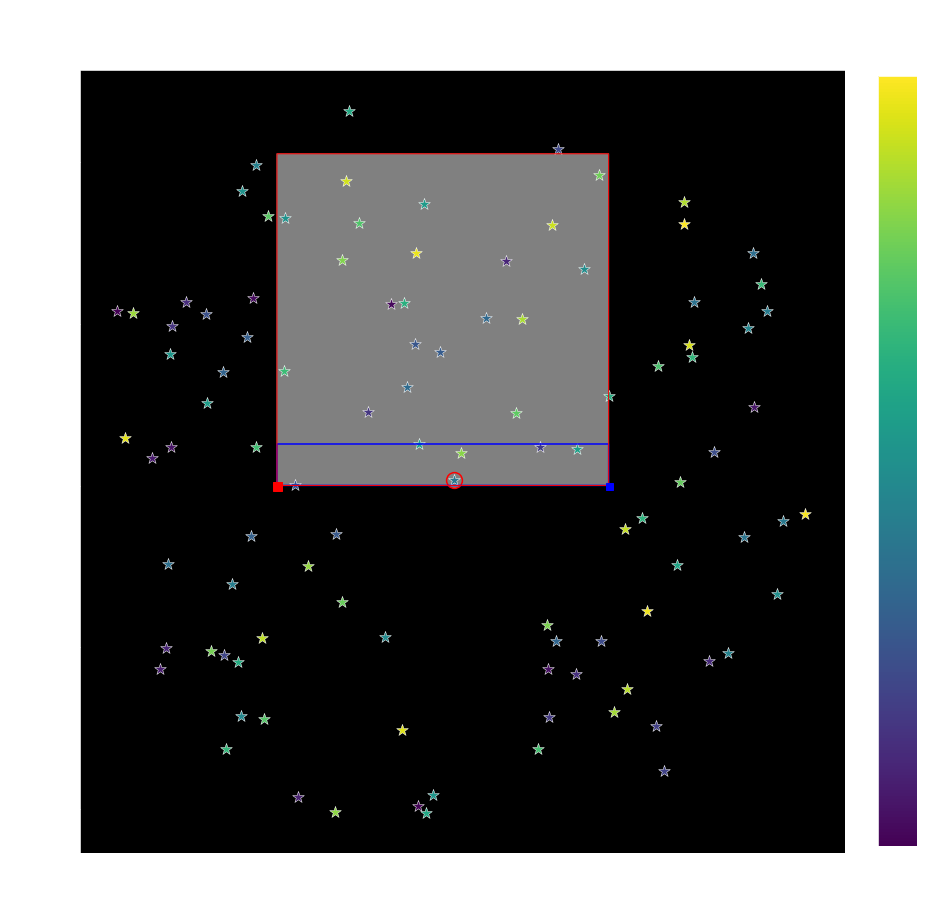

In [20]:
xdet = stars['xdet']
ydet = stars['ydet']

# Plotting
plt.figure(figsize=(15,15))
aper.plot(frame='det', fill_color=None, color='blue')
full.plot(frame='det', fill_color='gray', alpha=1.0, color='red', lw=1)
plt.scatter(xdet[targetIndex], ydet[targetIndex], s=250, lw=1.5, facecolor='gray', edgecolor='red')
plotTemps(starsT, xdet, ydet)
aper.plot_frame_origin(frame='det', which='sci')
aper.plot_frame_origin(frame='det', which='det')

# Plot styling
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
tdetx, tdety = str(round(xdet[targetIndex])), str(round(ydet[targetIndex]))
fullstr = str(full.AperName.replace('_', ' '))
plt.title('The FOV in DETECTOR coordinates at APA {}$^o$'.format(str(APA))+'\n'+'{}'.format(fullstr)+'\n'+'Target (X,Y): {}, {}'.format(tdetx, tdety), fontsize=20)

### Step 5: Removing neighbor sources that don't land on the MIRI detector <br/>

A star does not have to land within the sub-array for its spectra to be picked up. For this reason, our software considers sources landing on the _detector_ as potential contaminants. That being said, if a star does not land on the detector, we don't have to worry about it, so the next step is to eliminate those sources. To do this we set boundary conditions using the dimensions of the detector provided by `pySIAF`.

In [21]:
# Full Frame dimensions
rows, cols = full.corners('det')

minrow, maxrow = rows.min(), rows.max()
mincol, maxcol = cols.min(), cols.max()

inFOV = []
for star in range(0, nStars):

    x, y = stars['xdet'][star], stars['ydet'][star]
    if (mincol<x) & (x<maxcol) & (minrow<y) & (y<maxrow):
        inFOV.append(star)
        
inFOV = np.array(inFOV)

Text(0.5, 1.0, 'The FOV in DETECTOR coordinates at APA 0$^o$\nNRCA5 FULL\nTarget (X,Y): 1094.0, 33.0')

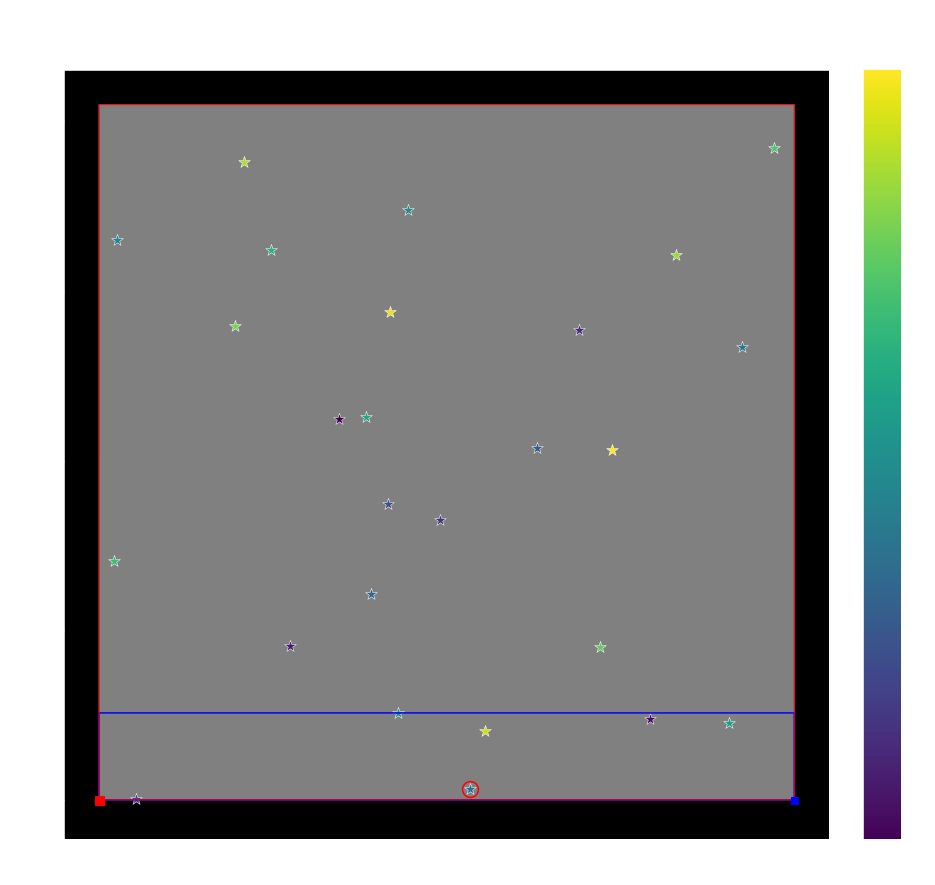

In [22]:
# Plotting
plt.figure(figsize=(15,15))
aper.plot(frame='det', fill_color=None, color='blue')
full.plot(frame='det', fill_color='gray', alpha=1.0, color='red', lw=1)
plt.scatter(xdet[targetIndex], ydet[targetIndex], s=250, lw=1.5, facecolor='gray', edgecolor='red')
plotTemps(starsT[inFOV], xdet[inFOV], ydet[inFOV])
aper.plot_frame_origin(frame='det', which='sci')
aper.plot_frame_origin(frame='det', which='det')

# Plot styling
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('The FOV in DETECTOR coordinates at APA {}$^o$'.format(str(APA))+'\n'+'{}'.format(fullstr)+'\n'+'Target (X,Y): {}, {}'.format(tdetx, tdety), fontsize=20)

The following output is essentially our final plot without the traces. What you see are all the sources that land on the _detector_ at the given position angle, at their science (x,y) pixel positons relative to the sub-array (blue). As before, the target is circled in red, and the readout location is designated by the blue square.

Text(0.5, 1.0, 'The FOV in SCIENCE coordinates at APA 0$^o$\nNRCA5 GRISM256 F444W\nTarget (X,Y): 955.0, 33.0')

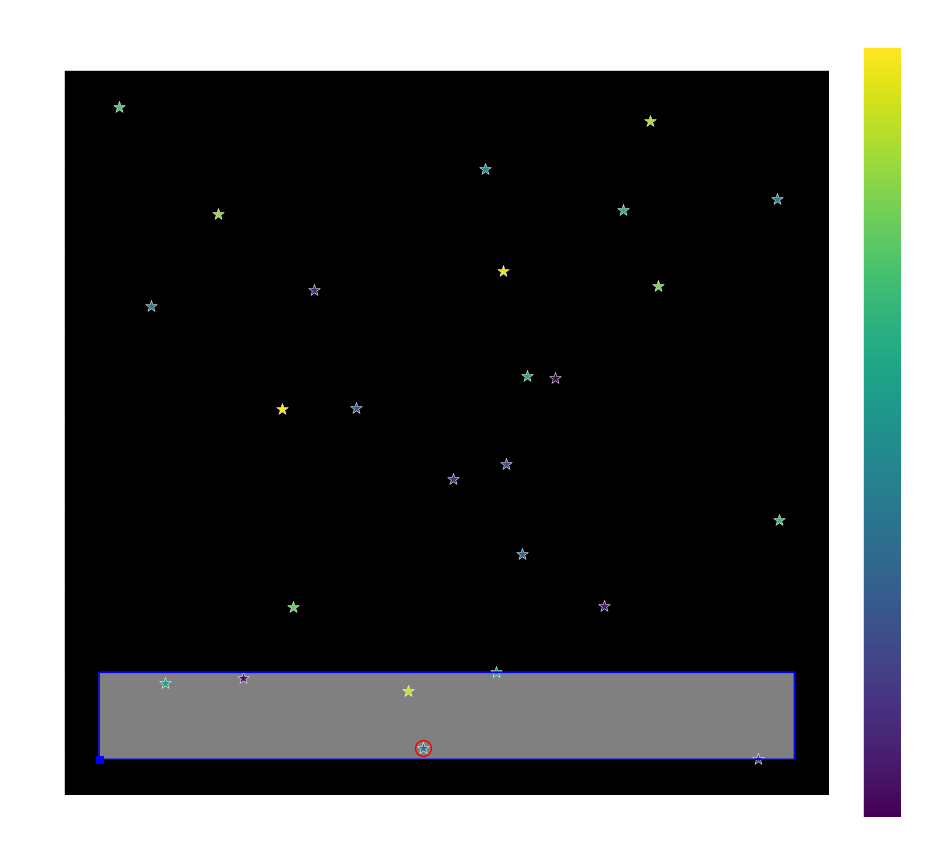

In [23]:
xsci, ysci = stars['xsci'][inFOV], stars['ysci'][inFOV]

# Plotting
plt.figure(figsize=(15,15))
aper.plot(frame='sci', fill_color='gray', color='blue')
plt.scatter(xsci[targetIndex], ysci[targetIndex], s=250, lw=1.5, facecolor='gray', edgecolor='red')
plotTemps(starsT[inFOV], xsci, ysci)
aper.plot_frame_origin(frame='sci', which='sci')

# Plot styling
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
aperstr = str(aper.AperName.replace('_', ' '))
tx, ty = (str(round(xsci[targetIndex]))), str(round(ysci[targetIndex]))
plt.title('The FOV in SCIENCE coordinates at APA {}$^o$'.format(str(APA))+'\n'+'{}'.format(aperstr)+'\n'+'Target (X,Y): {}, {}'.format(tx, ty), fontsize=20)

### Step 6: Generate the cube with a simulated field at every APA <br/>

The last step is to "paste" the assigned spectral trace for each star at its correct location relative to the target star, and repeat this process for all possible position angles (0-359). The end result is a 3-dimensional cube of shape 360 x nRows x nCols (where nRows and nCols are the Y, X dimensions of the sub-array). Below is a plot showing a rough estimate of where the traces for each source would land on the detector. Anything that lands within the gray region (the subarray) is what we predict you would see in your science images when opened on an imaging application such as DS9.

(51, 1343)


Text(0.5, 1.0, 'The FOV in SCIENCE coordinates at APA 0$^o$\nNRCA5 GRISM256 F444W\nTarget (X,Y): 955.0, 33.0')

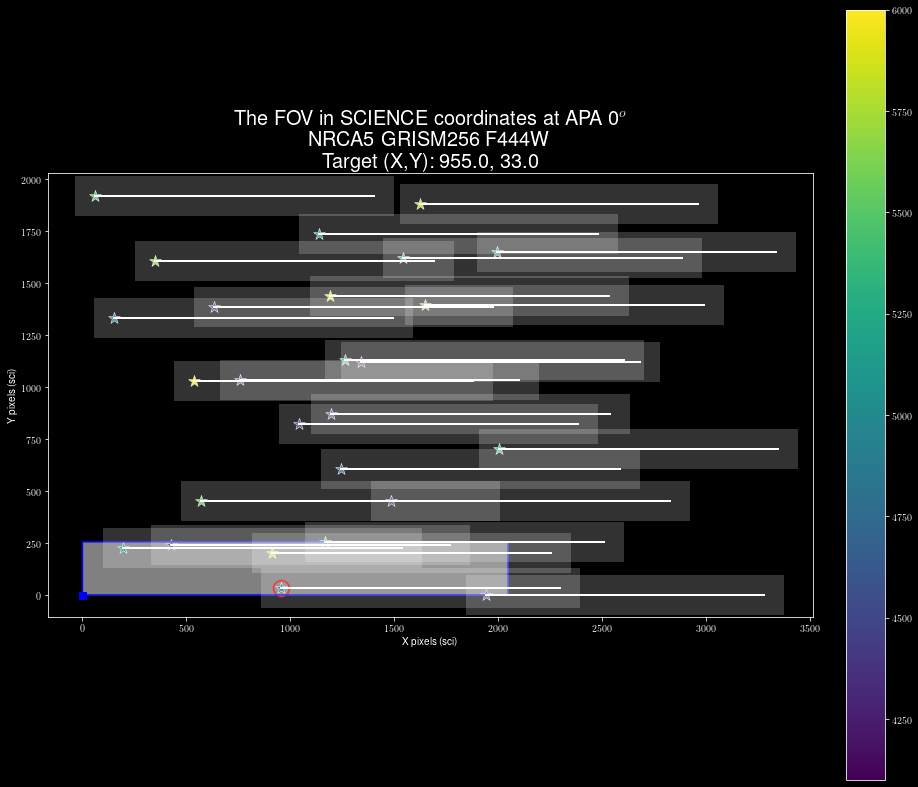

In [38]:
# Plotting
plt.figure(figsize=(15,15))
aper.plot(frame='sci', fill_color='gray', color='blue')
plt.scatter(xsci[targetIndex], ysci[targetIndex], s=250, lw=1.5, facecolor='gray', edgecolor='red')
plotTemps(starsT[inFOV], xsci, ysci)
aper.plot_frame_origin(frame='sci', which='sci')

# Fine-tune trace lengths
start, stop = traceLength(INSTRUMENT)

# Plotting the trace footprints
for x, y in zip(xsci, ysci):
    
    if 'NIRCam F322W2' in INSTRUMENT:
        plt.plot([x-stop, x+start], [y, y], lw=40, color='white', alpha=0.2)
        plt.plot([x-stop, x+start], [y, y], lw=2., color='white')
    elif 'NIRCam F444W' in INSTRUMENT:
        plt.plot([x-start, x+stop], [y, y], lw=40, color='white', alpha=0.2)
        plt.plot([x-start, x+stop], [y, y], lw=2., color='white')
    else:
        plt.plot([x, x], [y-stop, y+start], lw=40, color='white', alpha=0.2)
        plt.plot([x, x], [y-stop, y+start], lw=2., color='white')

plt.title('The FOV in SCIENCE coordinates at APA {}$^o$'.format(str(APA))+'\n'+'{}'.format(aperstr)+'\n'+'Target (X,Y): {}, {}'.format(tx, ty), fontsize=20)

### That's it! <br/>

We have a built-in function that performs all of the main tasks above in a few lines. When you want to come back and check the contamination outputs for different variations of APAs, instruments, and/or targets, simply run the commands in the cell below or in a terminal.

Generating FOV...
Querying for point-sources within 0.5 arcminutes...
Total point-sources found in region: 3
Calculating effective temperatures...
Converting Sky --> Science coordinates...
Saving figures to: /user/jmedina/exoctk_data/exoctk_data/exoctk_contam/traces/contam_19:50:50.2400_+48:04:51.00_MIRI.pdf
This will take a second...
(427, 55)
(427, 55)
(427, 55)
(427, 55)
(427, 55)


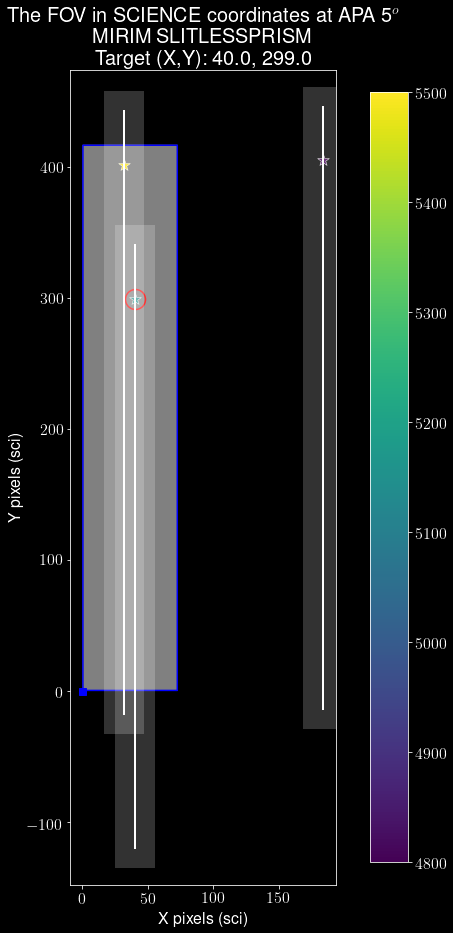

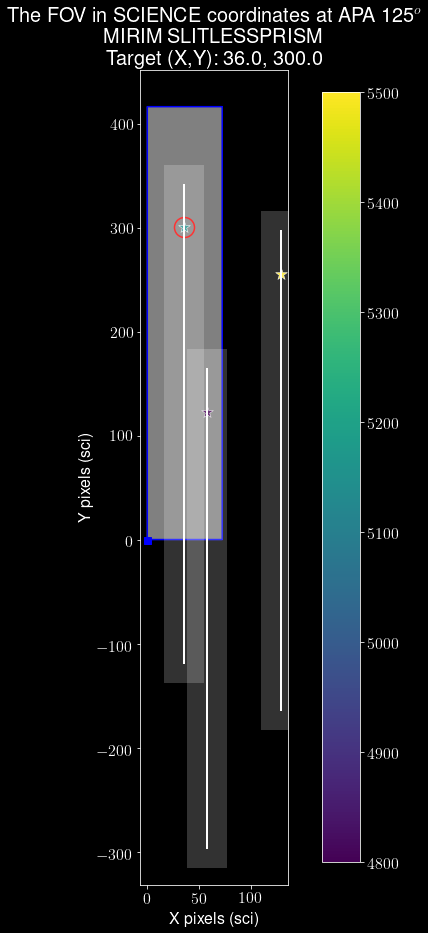

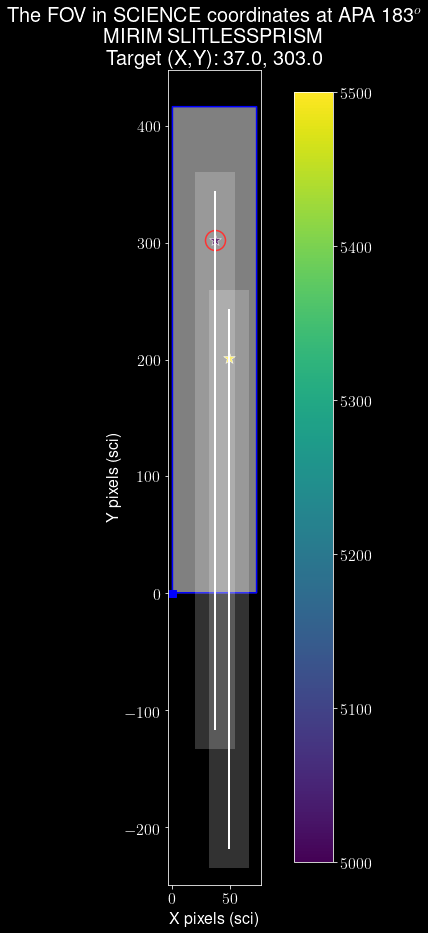

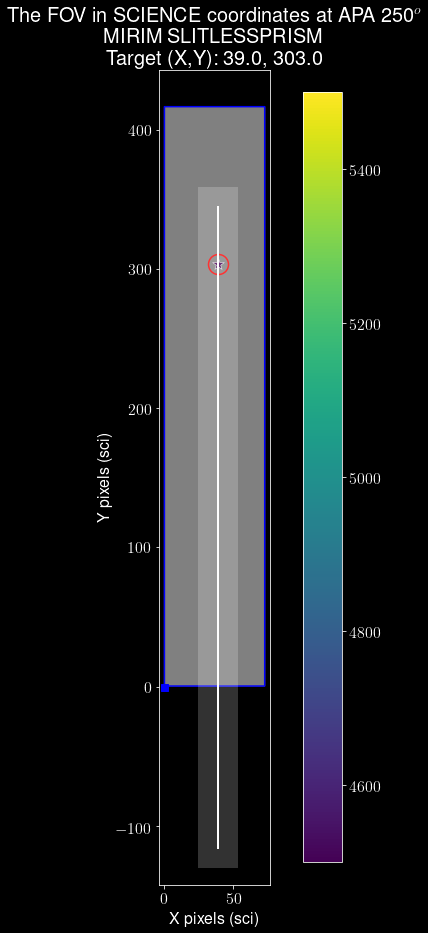

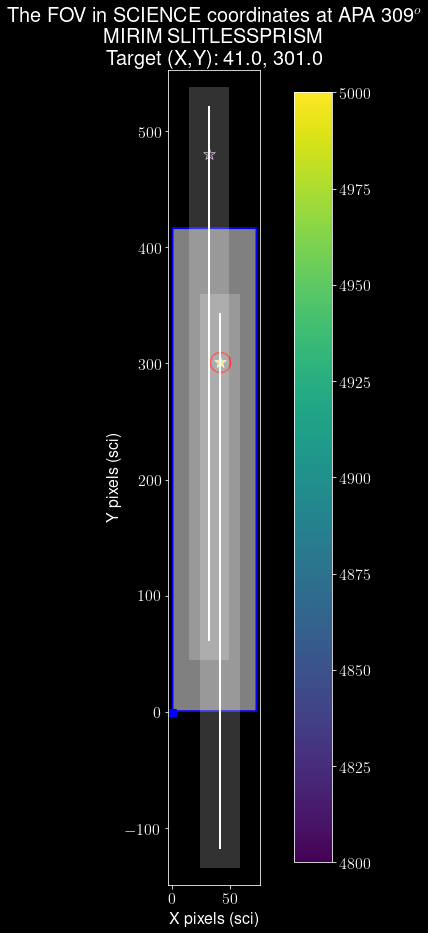

In [863]:
from exoctk.contam_visibility.miniTools import contamVerify

APA = [5, 125, 183, 250, 309]
pdfname = contamVerify(RA, DEC, 'MIRI', APA, binComp=[], PDF='', web=True)